## 读取数据
1.每条训练样本由95列构成，含义如下:  
\[0\]：样本id，无有效信息，可删除  
\[1,40\]：所在州的one-hot表示  
\[41,58\]：2d前的特征  
\[59,76\]：1d前的特征  
\[77,95\]：当天特征  
2.将样本重新组合成1d、2d、3d三种数据集，数据维度如下:  

day | train | pred
  - | - | -  
1    |(9886, 58)|(893, 57)|  
2    |(6293, 76)|(893, 75)|  
3    |(2700, 94)|(893, 93)|


In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
np.random.seed(69420)
tf.random.set_seed(69420)

train_file = "covid.train_v2.csv"
test_file = "covid.test_v2.csv"

def read_file(filename,mode,dayType):
    df = pd.read_csv(filename)
    cols = df.columns
    state_cols = list(cols[1:41])
    day1_cols = list(cols[41:59])
    day2_cols = list(cols[59:77])
    day3_cols = list(cols[77:])
    res = []
    if dayType == 1:
        train_cols = state_cols + day1_cols
        day1_df = df[state_cols+day1_cols]
        day2_df = df[state_cols+day2_cols]
        day3_df = df[state_cols+day3_cols]
        day1_df.columns = train_cols
        day2_df.columns = train_cols
        if("test" == mode):
            day3_df.columns = train_cols[:-1]
            train_df = pd.concat([day1_df,day2_df])
            res.append(train_df)
            res.append(day3_df)
        elif("train" == mode):
            day3_df.columns = train_cols
            train_df = pd.concat([day1_df,day2_df,day3_df])
            res.append(train_df)
    elif dayType == 2:
        train_cols = state_cols + day1_cols + day2_cols
        day1_df = df[state_cols+day1_cols+day2_cols]
        day2_df = df[state_cols+day2_cols+day3_cols]
        day1_df.columns = train_cols
        if("test" == mode):
            day2_df.columns = train_cols[:-1]
            res.append(day1_df)
            res.append(day2_df)
        elif("train" == mode):
            day2_df.columns = train_cols
            train_df = pd.concat([day1_df,day2_df])
            print(day1_df)
            res.append(train_df)
    elif dayType == 3:
        train_cols = state_cols + day1_cols + day2_cols + day3_cols
        day1_df = df[train_cols]
        if("test" == mode):
#             select_cols = ['cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'tested_positive', 'cli.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'tested_positive.1', 'cli.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2']
#             day1_df = df[state_cols+select_cols]
            res.append(pd.DataFrame())
            res.append(day1_df)
        elif("train" == mode):
#             select_cols = ['cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'tested_positive', 'cli.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'tested_positive.1', 'cli.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2','tested_positive.2']
#             day1_df = df[state_cols+select_cols]
            res.append(day1_df)
    return res

def lstm_read_file(filename, d_type):
    df = pd.read_csv(filename)
    if d_type == 'train':
        df = df.sample(frac=1).reset_index(drop=True)
    cols = df.columns
    
    state_cols = list(cols[1:41])
    day1_cols = list(cols[41:58])
    day2_cols = list(cols[59:76])
    if d_type=='train':
        day3_cols = list(cols[77:-1])
    elif d_type=='test':
        day3_cols = list(cols[77:])
        
    train_cols = state_cols + day1_cols + day2_cols + day3_cols
    
    day1_arr = np.expand_dims(df[day1_cols].to_numpy(), axis=1)
    day2_arr = np.expand_dims(df[day2_cols].to_numpy(), axis=1)
    day3_arr = np.expand_dims(df[day3_cols].to_numpy(), axis=1)
    
    state_arr = df[state_cols].to_numpy()
    tp1 = np.expand_dims(df['tested_positive'].to_numpy(), axis=1)
    tp2 = np.expand_dims(df['tested_positive.1'].to_numpy(), axis=1)
    
    res = []
    res.append(np.concatenate((state_arr, tp1, tp2), axis=1))
    res.append(np.concatenate((day1_arr, day2_arr, day3_arr), axis=1))
    if d_type == 'train': res.append(df['tested_positive.2'].to_numpy())
        
    return res

def read_train_test(train_file,test_file,dayType):
    train_res = read_file(train_file,"train",dayType)
    test_res = read_file(test_file,"test",dayType)
    train_df = pd.concat([train_res[0],test_res[0]])
    return train_df,test_res[1]

def lstm_read_train_test(train_file,test_file):
    train_res = lstm_read_file(train_file, 'train')
    test_res = lstm_read_file(test_file, 'test')
    return train_res, test_res

lstm_train_arr,lstm_test_arr = lstm_read_train_test(train_file,test_file)

train_1d_df,test_1d_df = read_train_test(train_file,test_file,1)
train_2d_df,test_2d_df = read_train_test(train_file,test_file,2)
train_3d_df,test_3d_df = read_train_test(train_file,test_file,3)
train_1d_df


       AL   AK   AZ   AR   CA   CO   CT   FL   GA   ID  ...  restaurant.1  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.688882   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.812411   
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.682974   
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.593983   
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     22.576992   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...           ...   
2135  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     13.599652   
2136  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     13.734133   
2137  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     13.428415   
2138  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     13.405587   
2139  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     13.545148   

      spent_time.1  large_event.1  public_transit.1  anxious.1  depressed.1

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.835119,44.726055,16.946929,1.716262,15.494193,12.043275,17.000647,53.439316,43.279629,19.586492
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.462823,31.656358,8.239559,1.789015,14.808636,11.371546,19.257324,67.691795,38.953184,13.434180
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.090116,30.839219,7.849525,1.760094,14.617563,11.163213,18.742673,68.024690,38.920206,13.008853
557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.779264,30.617100,7.754800,1.780730,14.513419,11.281241,18.539741,67.855755,39.224244,12.725638
558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.961085,30.595194,7.744075,1.921828,14.160990,11.163526,18.702564,67.731162,38.740651,12.613441


## 特征工程  
特征归一化：将非one-hot特征缩放至0~1范围  
样本shuffle：原始数据中样本按州排序，需要将样本随机打散  
数据拆分：将数据集拆分为训练集和测试集，其中测试集占比10%  

day | train | test
  - | - | -  
1    |(8897, 57)|(989, 57)|  
2    |(5663, 75)|(630, 75)|  
3    |(2430, 93)|(270, 93)|

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def scale_fea(sc,features,mode):
    state = features.values[:,:40]
    other_fea = features.values[:,40:]
    if('train' == mode):
        other_fea = features.values[:,40:]
        sc_other_fea = sc.fit_transform(other_fea)
    else:
        sc_other_fea = sc.transform(other_fea)
    res = np.hstack((state,sc_other_fea))
    return res

def lstm_scale_fea(sc, features, mode, refit=False):
    origin_shape = features.shape
    state = []
    other_fea = []
    
    if mode == 'static':
        state     = features[:,:40]
        other_fea = features[:,40:]
    elif mode == 'timeseries':
        other_fea = features[:,:]
        other_fea = other_fea.reshape(-1, other_fea.shape[-1])
    
    if refit:
        sc.fit(other_fea)
    sc_other_fea = sc.transform(other_fea)
    
    if mode == 'static':
        res = np.hstack((state,sc_other_fea))
    elif mode == 'timeseries':
        res = sc_other_fea.reshape(origin_shape)
    return res

def gen_feature(train_df):
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    l_col = train_df.columns[-1]
    labels = train_df[l_col]
    features = train_df.drop(columns=[l_col])
    train_x,test_x,train_y,test_y = train_test_split(features,labels,test_size = 0.1)
    sc = StandardScaler()
    train_x = scale_fea(sc,train_x,'train')
    test_x = scale_fea(sc,test_x,'test')
    return train_x,train_y,test_x,test_y,sc

def lstm_gen_feature(train_arr):
    static_features = train_arr[0]
    timeseries_features = train_arr[1]
    labels = train_arr[2]
    
    test_percent = 0.1
    train_actual_size = int(labels.shape[0] * (1.0-test_percent))
    test_actual_size = labels.shape[0] - train_actual_size
    
    train_x_static, train_x_timeseries = static_features[:train_actual_size], timeseries_features[:train_actual_size]
    test_x_static,  test_x_timeseries  = static_features[train_actual_size:], timeseries_features[train_actual_size:]
    train_y,        test_y             = labels[:train_actual_size]         , labels[train_actual_size:]       
    
    sc_static     = StandardScaler()
    sc_timeseries = StandardScaler()
    
    train_x_static     = lstm_scale_fea(sc_static,train_x_static,'static', True)
    test_x_static      = lstm_scale_fea(sc_static,test_x_static, 'static', False)
    train_x_timeseries = lstm_scale_fea(sc_timeseries,train_x_timeseries,'timeseries', True)
    test_x_timeseries  = lstm_scale_fea(sc_timeseries,test_x_timeseries ,'timeseries', False)

    return train_x_static, train_x_timeseries, train_y, test_x_static, test_x_timeseries, test_y, sc_static, sc_timeseries

train_1d_x,train_1d_y,test_1d_x,test_1d_y,sc_1d = gen_feature(train_1d_df)
train_2d_x,train_2d_y,test_2d_x,test_2d_y,sc_2d = gen_feature(train_2d_df)
# train_3d_x,train_3d_y,test_3d_x,test_3d_y,sc_3d = gen_feature(train_3d_df)

train_3d_x_static, train_3d_x_timeseries, lstm_train_3d_y, \
test_3d_x_static, test_3d_x_timeseries, lstm_test_3d_y, \
sc_3d_static, sc_3d_timeseries = lstm_gen_feature(lstm_train_arr)

print(train_3d_x_static.shape)
print(train_3d_x_timeseries.shape)
print(test_3d_x_static.shape)
print(test_3d_x_timeseries.shape)

(1926, 42)
(1926, 3, 17)
(214, 42)
(214, 3, 17)


## 模型构造与训练  
使用dnn为三种数据集构建三个不同的模型,测试结果如下 

day | loss | rmse
  - | - | -  
1    |0.531236|0.728859|  
2    |0.497631|0.705429|  
3    |0.912615|0.955309|  

  
  


In [41]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,Concatenate,LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import regularizers

class ResBlock(layers.Layer):
    def __init__(self, input_nodes, blocks):
        super(ResBlock, self).__init__()
        self.blocks = blocks

        self.dense1 = layers.Dense(input_nodes)
        self.act_relu = layers.Activation('relu')

        self.dense2 = layers.Dense(input_nodes)
        self.dense3 = layers.Dense(input_nodes)
      

    def call(self, inputs, training=None):

        x = self.dense1(inputs)
        x = self.act_relu(x)
        x = self.dense2(x)
        x = self.act_relu(x)
        if self.blocks==3:
            x = self.dense3(x)
            x = self.act_relu(x)
        outputs = layers.add([x,inputs])
        outputs = self.act_relu(x)

        return outputs

def build_model(featureLen,dayType):
    if dayType == 1:
        network = Sequential()
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0001)
        """
        network.add(Dense(70,activation='relu',input_shape=(featureLen,)))
        network.add(ResBlock(70, 3))
        network.add(Dense(2, activation='relu', name='transfer_features'))
        network.add(Dense(1))
        sch = ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9)
        opt = Adam(learning_rate = sch)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    elif dayType == 2:
        network = Sequential()
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0001)
        """
        network.add(Dense(70,activation='relu',input_shape=(featureLen,)))
        network.add(ResBlock(70, 3))
        network.add(Dense(4, activation='relu', name='transfer_features'))
        network.add(Dense(1))
        sch = ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9)
        opt = Adam(learning_rate = sch)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    elif dayType == 3:
        network = Sequential()
        """
        network.add(Dense(32,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(16,activation='relu'))
        network.add(Dense(8,activation='relu'))
        network.add(Dense(4,activation='relu'))
        network.add(Dense(2,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0002)
        """
#         network.add(Dense(32,activation='relu',input_shape=(featureLen,),kernel_regularizer=regularizers.l2(1e-5)))
#         network.add(Dense(4,activation='relu',kernel_regularizer=regularizers.l2(1e-5)))
#         network.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
#         network.add(Dense(1))
#         opt = Adam(learning_rate = 0.0001)
        network.add(Dense(128,activation=tf.nn.silu,kernel_regularizer=regularizers.l2(1e-4),input_shape=(featureLen,)))
        network.add(Dropout(0.5))
        network.add(ResBlock(128, 3))
#         network.add(Dense(128,activation=tf.nn.silu,kernel_regularizer=regularizers.l2(1e-4)))
#         network.add(Dropout(0.5))
        network.add(Dense(4, activation='relu', name='transfer_features'))
        network.add(Dense(1))
        sch = ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9)
        opt = SGD(learning_rate=sch, momentum=0.8)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return network

def lstm_build_model():
    timesteps = 3
    input_dim_time_series = 17
    input_dim_static = 42

    # Static features branch
#     static_input = Input(shape=(input_dim_static,), name='static_input')
#     dense1 = Dense(32,kernel_regularizer=regularizers.l2(0.001))(static_input)
#     dense1 = (LeakyReLU(alpha=0.05))(dense1)
    # Time-series branch
    time_series_input = Input(shape=(timesteps, input_dim_time_series), name='time_series_input')
    lstm1 = LSTM(8, return_sequences=True,kernel_regularizer=regularizers.l2(0.001))(time_series_input)
    lstm2 = LSTM(4, return_sequences=False,kernel_regularizer=regularizers.l2(0.001), name='transfer_feature')(lstm1)

    # Combine the outputs of both branches
#     combined = Concatenate()([lstm2, dense1])
#     combined = Dense(4,kernel_regularizer=regularizers.l2(0.001), name='transfer_feature')(lstm2)
#     combined = (LeakyReLU(alpha=0.05))(combined)
    # Regressor
#     dense2 = Dense(32, activation='relu')(combined)
    output = Dense(1)(lstm2)

    model = Model(inputs=[time_series_input], outputs=output)

    sch = ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9)
    opt = Adam(learning_rate = sch)
    model.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

def train_model(train_x,train_y,valid_size,featureLen,dayType,model_path,epoch,batch,patience,train_type='train'):
    network = build_model(featureLen,dayType)
    valid_x = train_x[:valid_size]
    partial_train_x = train_x[valid_size:]
    valid_y = train_y[:valid_size]
    partial_train_y = train_y[valid_size:]
    es = EarlyStopping(monitor='val_root_mean_squared_error',mode='min',verbose=1,patience=patience)
#     ckpt = ModelCheckpoint(model_path,monitor='val_root_mean_squared_error',save_best_only=True,verbose=1,mode='min')
    if('train' == train_type):
        history = network.fit(partial_train_x,partial_train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es]) #
    elif('total' == train_type):
        history = network.fit(train_x,train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es])#,callbacks=[es]
    return network,history

def lstm_train_model(train_x,train_y,valid_size,model_path,epoch,batch,patience,train_type):
    network = lstm_build_model()
    valid_x = train_x[:valid_size]
    partial_train_x = train_x[valid_size:]
    valid_y = train_y[:valid_size]
    partial_train_y = train_y[valid_size:]
    print(valid_size)
    es = EarlyStopping(monitor='val_root_mean_squared_error',mode='min',verbose=1,patience=patience, restore_best_weights=True)
    if('train' == train_type):
        history = network.fit(partial_train_x,partial_train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es]) #
    elif('total' == train_type):
        history = network.fit(train_x,train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es])#,callbacks=[es]
    return network,history

def train_day_model(train_x,train_y,test_x,test_y,dayType,model_path,epoch,batch,patience,train_type='train'):
    valid_size = int(train_x.shape[0]/10)
    featureLen = train_x.shape[1]
    network,history = train_model(train_x,train_y,valid_size,featureLen,dayType,model_path,epoch,batch,patience,train_type)
    test_loss, test_rmse = network.evaluate(test_x, test_y)
    print('test_loss:%f,test_rmse:%f'% (test_loss,test_rmse))
    return network,history

def train_lstm(train_x,train_y,test_x,test_y,model_path,epoch,batch,patience,train_type):
    valid_size = int(train_x.shape[0]/10)
    network,history = lstm_train_model(train_x,train_y,valid_size,model_path,epoch,batch,patience,train_type)
    test_loss, test_rmse = network.evaluate(test_x, test_y)
    print('test_loss:%f,test_rmse:%f'% (test_loss,test_rmse))
    return network,history

model_1d_path = "/kaggle/working/model_1d/"
model_2d_path = "/kaggle/working/model_2d/"
model_3d_path = "/kaggle/working/model_3d/"
epoch = 5000
batch = 200
patience = 300

train_lstm_x = [train_3d_x_static, train_3d_x_timeseries]
train_lstm_y = train_3d_y
test_lstm_x  = [test_3d_x_static, test_3d_x_timeseries]
test_lstm_y  = test_3d_y

network_lstm,history_lstm = train_lstm(train_lstm_x[1],train_lstm_y,test_lstm_x[1],test_lstm_y,model_3d_path,epoch,batch,patience,'train')
network_1d,history_1d = train_day_model(train_1d_x,train_1d_y,test_1d_x,test_1d_y,1,model_1d_path,epoch,batch,patience)
network_2d,history_2d = train_day_model(train_2d_x,train_2d_y,test_2d_x,test_2d_y,2,model_2d_path,epoch,batch,patience)
# network_3d,history_3d = train_day_model(train_3d_x,train_3d_y,test_3d_x,test_3d_y,3,model_3d_path,epoch,batch,patience)

192
Epoch 1/5000
9/9 [==============================] - 2s 62ms/step - loss: 301.5998 - root_mean_squared_error: 17.3657 - val_loss: 291.0884 - val_root_mean_squared_error: 17.0604
Epoch 2/5000
9/9 [==============================] - 0s 12ms/step - loss: 299.6893 - root_mean_squared_error: 17.3106 - val_loss: 289.1691 - val_root_mean_squared_error: 17.0040
Epoch 3/5000
9/9 [==============================] - 0s 14ms/step - loss: 297.6815 - root_mean_squared_error: 17.2525 - val_loss: 287.1071 - val_root_mean_squared_error: 16.9433
Epoch 4/5000
9/9 [==============================] - 0s 10ms/step - loss: 295.4857 - root_mean_squared_error: 17.1887 - val_loss: 284.8583 - val_root_mean_squared_error: 16.8768
Epoch 5/5000
9/9 [==============================] - 0s 9ms/step - loss: 293.0827 - root_mean_squared_error: 17.1187 - val_loss: 282.3583 - val_root_mean_squared_error: 16.8025
Epoch 6/5000
9/9 [==============================] - 0s 9ms/step - loss: 290.4214 - root_mean_squared_error: 17.0

## 绘制曲线

C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')

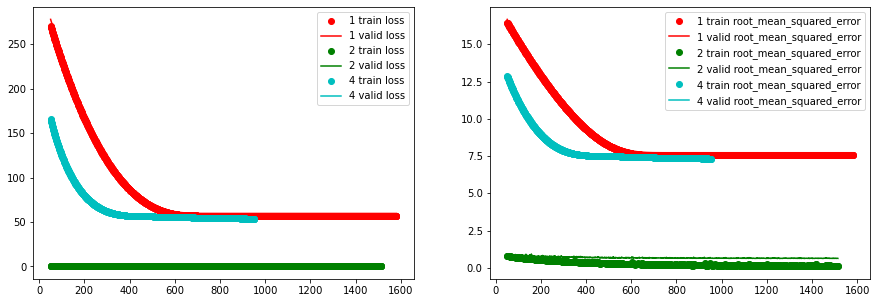

In [42]:
import matplotlib.pyplot as plt
colorMap = {1:'r',2:'g',3:'b', 4:'c'}

def plot_history(history,dayType):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    mae = history_dict['root_mean_squared_error']
    val_mae = history_dict['val_root_mean_squared_error']
    epochs = range(1,len(loss)+1)
    
    n = 50
    end = 2000
    plt.subplot(1,2,1)
    plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
    plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')
    plt.plot(epochs[n:end],val_mae[n:end],'b',c=colorMap[dayType],label=str(dayType)+ ' valid root_mean_squared_error')
    
plt.figure(figsize=(15,5))
plot_history(history_1d,1)
plot_history(history_2d,2)
# plot_history(history_3d,3)
plot_history(history_lstm,4)
plt.legend()
plt.show()

## 模型融合  
### 构造样本

In [43]:
def lstm_gen_test_feature(train_arr, sc_static, sc_timeseries):
    static_features = train_arr[0]
    timeseries_features = train_arr[1]
    
    train_x_static, train_x_timeseries = static_features, timeseries_features       
    
    train_x_static     = lstm_scale_fea(sc_static,    train_x_static,    'static',    False)
    train_x_timeseries = lstm_scale_fea(sc_timeseries,train_x_timeseries,'timeseries', False)

    return [train_x_static, train_x_timeseries]

def gen_merge_feature(train_3d_df, sc_lstm_features):
    part_d1_cols_d1 = cols[:40]+cols[-54:-37]
    part_d1_cols_d2 = cols[:40]+cols[-36:-19]
    part_d1_cols_d3 = cols[:40]+cols[-18:-1]
    part_d2_front_cols = cols[:40]+cols[-54:-36]+cols[-18:-1]
    part_d2_back_cols = cols[:40]+cols[-36:-18]+cols[-18:-1]
    
    part_d1_df_d1 = train_3d_df[part_d1_cols_d1]
    part_d1_df_d2 = train_3d_df[part_d1_cols_d2]
    part_d1_df_d3 = train_3d_df[part_d1_cols_d3]
    part_d2_front_df = train_3d_df[part_d2_front_cols]
    part_d2_back_df = train_3d_df[part_d2_back_cols]
    part_d3_df = train_3d_df[cols[:-1]]
    
    sc_d1_feature_d1 = scale_fea(sc_1d,part_d1_df_d1,'test')
    sc_d1_feature_d2 = scale_fea(sc_1d,part_d1_df_d2,'test')
    sc_d1_feature_d3 = scale_fea(sc_1d,part_d1_df_d3,'test')
    sc_d2_front_feature = scale_fea(sc_2d,part_d2_front_df,'test')
    sc_d2_back_feature = scale_fea(sc_2d,part_d2_back_df,'test')
    sc_d3_feature = scale_fea(sc_3d,part_d3_df,'test')
    
#     features_layer_d1_d1 = tf.keras.models.Model(
#     inputs=network_1d.inputs,
#     outputs=network_1d.get_layer(name="transfer_features").output,
#     )
#     features_layer_d1_d2 = tf.keras.models.Model(
#     inputs=network_1d.inputs,
#     outputs=network_1d.get_layer(name="transfer_features").output,
#     )
#     features_layer_d1_d3 = tf.keras.models.Model(
#     inputs=network_1d.inputs,
#     outputs=network_1d.get_layer(name="transfer_features").output,
#     )
    features_layer_d2_front = tf.keras.models.Model(
    inputs=network_2d.inputs,
    outputs=network_2d.get_layer(name="transfer_features").output,
    )
    features_layer_d2_back = tf.keras.models.Model(
    inputs=network_2d.inputs,
    outputs=network_2d.get_layer(name="transfer_features").output,
    )
#     features_layer_d3_1 = tf.keras.models.Model(
#     inputs=network_3d.inputs,
#     outputs=network_3d.get_layer(name="transfer_features").output,
#     )
    features_layer_lstm = tf.keras.models.Model(
    inputs=network_lstm.inputs,
    outputs=network_lstm.get_layer(name='transfer_feature').output,
    )
    
#     pred_1d_d1_feature = features_layer_d1_d1.predict(sc_d1_feature_d1)
#     pred_1d_d2_feature = features_layer_d1_d2.predict(sc_d1_feature_d2)
#     pred_1d_d3_feature = features_layer_d1_d3.predict(sc_d1_feature_d3)
#     pred_1d_d1 = network_1d.predict(sc_d1_feature_d1)
#     pred_1d_d2 = network_1d.predict(sc_d1_feature_d2)
    pred_1d_d3 = network_1d.predict(sc_d1_feature_d3)
    pred_2d_front_feature = features_layer_d2_front.predict(sc_d2_front_feature)
    pred_2d_back_feature = features_layer_d2_back.predict(sc_d2_back_feature)
#     pred_3d_feature = features_layer_d3_1.predict(sc_d3_feature)
    pred_lstm_feature = features_layer_lstm.predict(sc_lstm_features[1])

    merge_feature = np.hstack([pred_1d_d3, pred_2d_front_feature, pred_2d_back_feature, pred_lstm_feature])
#     merge_feature = tf.keras.utils.normalize(merge_feature)
#     print(merge_feature)
    return merge_feature

lstm_train_feature = lstm_gen_test_feature(lstm_train_arr, sc_3d_static, sc_3d_timeseries)

cols=list(train_3d_df.columns)
merge_feature = gen_merge_feature(train_3d_df, lstm_train_feature)
merge_labels = train_3d_df[cols[-1]]
train_merge_x,test_merge_x,train_merge_y,test_merge_y = train_test_split(merge_feature,merge_labels,test_size = 0.1)
print(train_merge_x.shape)

(1926, 13)


### 模型训练

In [44]:
def build_merge_model():
    network = Sequential()
    network.add(Dense(35,activation='relu',input_shape=(13,),kernel_regularizer=regularizers.l2(1e-5))) #activation='relu',
    network.add(Dense(4,activation='relu',kernel_regularizer=regularizers.l2(1e-5)))
    network.add(Dense(1))
    sch = ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9)
    opt = Adam(learning_rate = sch)
    network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return network

def train_merge_model(train_x,train_y,test_x, test_y,model_path,epoch,batch,patience,train_type='train'):
    network = build_merge_model()
    valid_size = int(train_x.shape[0]/10)
    valid_x = train_x[:valid_size]
    partial_train_x = train_x[valid_size:]
    valid_y = train_y[:valid_size]
    partial_train_y = train_y[valid_size:]
    es = EarlyStopping(monitor='val_root_mean_squared_error',mode='min',verbose=1,patience=patience)
    ckpt = ModelCheckpoint(model_path,monitor='val_root_mean_squared_error',save_best_only=True,verbose=1,mode='min')
    if('train' == train_type):
        history = network.fit(partial_train_x,partial_train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es]) #
    elif('total' == train_type):
        history = network.fit(train_x,train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es,ckpt])#,callbacks=[es]
    test_loss, test_rmse = network.evaluate(test_x, test_y)
    print('test_loss:%f,test_rmse:%f'% (test_loss,test_rmse))
    return network,history

model_merge_path = "/kaggle/working/model_merge/"
merge_epoch = 500
merge_batch = 10
merge_patience = 50
network_merge,history_merge = train_merge_model(train_merge_x,train_merge_y,test_merge_x,test_merge_y,model_merge_path,epoch,batch,patience)

Epoch 1/5000
9/9 [==============================] - 0s 13ms/step - loss: 662.9976 - root_mean_squared_error: 25.7487 - val_loss: 552.5786 - val_root_mean_squared_error: 23.5070
Epoch 2/5000
9/9 [==============================] - 0s 4ms/step - loss: 444.6099 - root_mean_squared_error: 21.0858 - val_loss: 359.1468 - val_root_mean_squared_error: 18.9512
Epoch 3/5000
9/9 [==============================] - 0s 5ms/step - loss: 281.7123 - root_mean_squared_error: 16.7843 - val_loss: 219.5043 - val_root_mean_squared_error: 14.8157
Epoch 4/5000
9/9 [==============================] - 0s 5ms/step - loss: 165.4266 - root_mean_squared_error: 12.8618 - val_loss: 120.4622 - val_root_mean_squared_error: 10.9755
Epoch 5/5000
9/9 [==============================] - 0s 5ms/step - loss: 83.4981 - root_mean_squared_error: 9.1377 - val_loss: 53.3421 - val_root_mean_squared_error: 7.3036
Epoch 6/5000
9/9 [==============================] - 0s 5ms/step - loss: 32.8557 - root_mean_squared_error: 5.7320 - val_los

### 效果检查

0.10400595456622835 0.014513843531901643


C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')

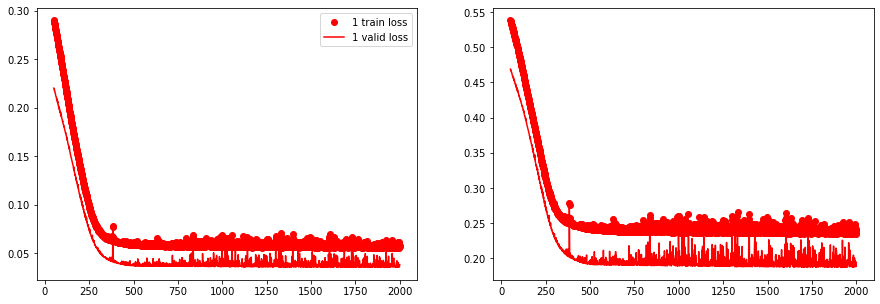

In [45]:
#35node-merge-regularizer
pred_merge = network_merge.predict(test_merge_x)
diff = pred_merge.reshape(1,-1)[0] - test_merge_y.values
weights = network_merge.get_weights()
print(np.mean(abs(diff)),np.var(diff))
# print(weights)
plt.figure(figsize=(15,5))
plot_history(history_merge,1)

0.10400595456622835 0.014513843531901643


C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')

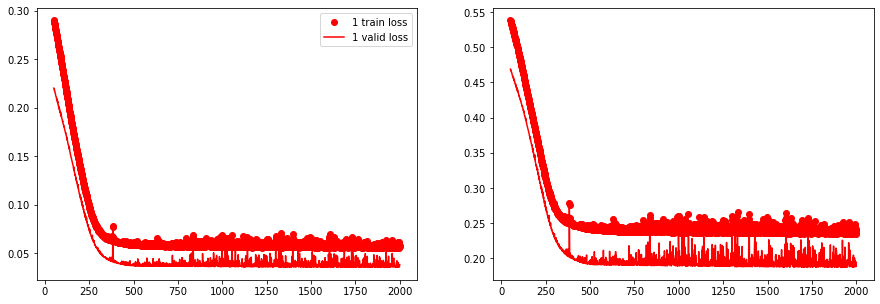

In [46]:
#35node-merge
pred_merge = network_merge.predict(test_merge_x)
diff = pred_merge.reshape(1,-1)[0] - test_merge_y.values
weights = network_merge.get_weights()
print(np.mean(abs(diff)),np.var(diff))
# print(weights)
plt.figure(figsize=(15,5))
plot_history(history_merge,1)

0.10400595456622835 0.014513843531901643


C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
C:\Users\ESALAB\AppData\Local\Temp\ipykernel_19332\3166318960.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')

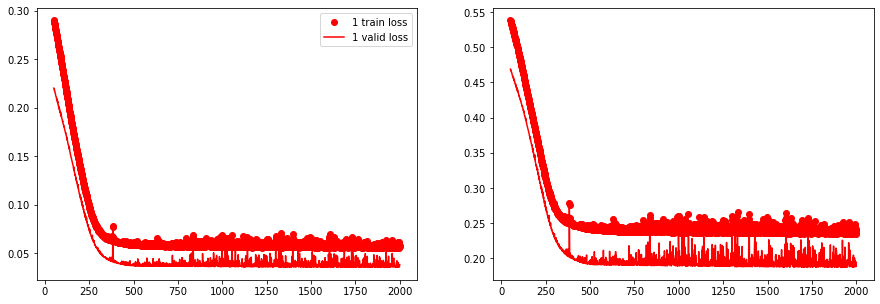

In [47]:
#40node-merge
pred_merge = network_merge.predict(test_merge_x)
diff = pred_merge.reshape(1,-1)[0] - test_merge_y.values
weights = network_merge.get_weights()
print(np.mean(abs(diff)),np.var(diff))
# print(weights)
plt.figure(figsize=(15,5))
plot_history(history_merge,1)

In [48]:
test_orig_file = "covid.test_v2.csv"
res_file = "resnet-lstm_merge_submit-4.csv"
lstm_test_feature = lstm_gen_test_feature(lstm_test_arr, sc_3d_static, sc_3d_timeseries)
test_feature = gen_merge_feature(test_3d_df, lstm_test_feature)
pred = network_merge.predict(test_feature)

In [49]:
with open(res_file,'w') as f_out:
    f_out.write("id,tested_positive\n")
    for i in range(pred.shape[0]):
        outline = str(i)+","+str(pred[i][0])+"\n"
        f_out.write(outline)
print("end")

end
